In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from scipy.io import loadmat
import matplotlib.cm as cm
from scipy.optimize import fmin_cg

In [4]:
import theme
theme.load_style()

# Exercise 4: Neural Networks Learning

## 1 Neural Networks

### 1.1 Visualizing the Data

In [5]:
m = loadmat('data/ex3data1.mat')
X = m['X']
y = m['y'].flatten()
y[where(y==10)] = 0

In [6]:
m = loadmat('data/ex4weights.mat')
Theta1 = m['Theta1']
Theta2 = m['Theta2']

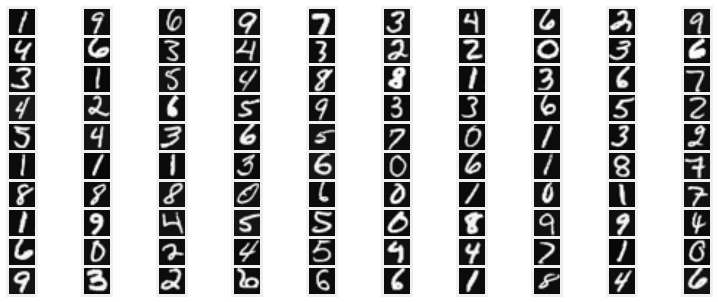

In [7]:
def display_data(X):
    nrows = ncols = 10
    ix = random.randint(0, X.shape[0]-1, nrows * ncols)
    p, axs = plt.subplots(nrows=nrows, ncols=ncols)
    k = 0
    for i in range(nrows):
        for j in range(ncols):
            axs[i, j].imshow(X[ix[k]].reshape((20,20)).T, cmap=cm.Greys_r)
            axs[i, j].grid(False)
            setp(axs[i,j].get_xticklabels(), visible=False)
            setp(axs[i,j].get_yticklabels(), visible=False)
            k += 1
    tight_layout(pad=0)
display_data(X)

In [8]:
def sigmoid(z):
    return 1. / (1. + exp(-z))

def sigmoid_grad(z):
    return sigmoid(z) * (1 - sigmoid(z))

def initial_weights(sizes, eps=.12):
    assert len(sizes) >= 3
    p = lambda a, b: 2 * eps * random.random((b, a + 1)) - eps
    theta = []
    for i in range(len(sizes) - 1):
        theta.append(p(sizes[i], sizes[i+1]))
    return theta

In [40]:
def nn_costfun(theta, X, y=None, sizes=None, lam=None, disp=None):
  
    # reshape theta
    # compute the prediction.  the prediction h_theta will be
    # contained in a[-1] on completion
    X = asarray(X)
    m = X.shape[0]   
    a, z = [X], []
    for t in theta:
        a[-1] = column_stack((ones(m), a[-1]))
        z.append(a[-1].dot(t.T))
        a.append(sigmoid(z[-1]))
    
    if disp == 1:
        return a[-1]
    
    # compute the cost
    r = tile(range(sizes[-1]), (m, 1))
    v = tile(y[:,newaxis], (1, sizes[-1]))
    yv = array(r == v, dtype=int)
    if yv.shape != a[-1].shape:
        if yv.shape[0] != a[-1].shape:
            raise ValueError('Wrong number of predictions')
        else:
            raise ValueError('Wrong number of prediction classes')
    
    eps = 1.e-6
    J = -sum(yv * log(a[-1] + eps) + ((1 - yv) * log(1 - a[-1] + eps))) / m
    if lam is not None:
        J += lam / 2 / m * sum([sum(t[:,1:] ** 2) for t in theta])        
    
    if disp == 2:
        return J
    
    # Backprop error
    delta = []
    
    # Get Error for output layer
    error = a[-1] - yv
    delta.append(error)

    # Get error for hidden layers working backwards
    lt = len(theta)
    for i in range(lt-1, 0, -1):
        error = error.dot(theta[i][:,1:]) * (a[i][:,1:] * (1 - a[i][:,1:]))
        delta.append(error)
    
    # Reverse the list so that delta[i] is delta that theta[i] 
    # causes on a[i+1]
    delta.reverse()

    # Calculate gradient from delta and activation
    # i is the theta from layer i to layer i+1
    grad = []
    for i in range(lt):
        grad.append(dot(delta[i].T, a[i]) / m)

    # average error + regularization penalty 
    if lam is not None:
        for i in range(lt):
            grad[i][:,1:] += lam / m * theta[i][:,1:]
    
    if disp == 3:
        return grad
    
    return J, grad

In [41]:
def roll(a, sizes):
    i, ar = 0, []    
    for (_, k) in enumerate(sizes[1:]):
        j = sizes[_]
        ar.append(reshape(a[i:i+(k*(j+1))], (k, j+1)))
        i += k * (j + 1)
    return ar
 
def unroll(a):
    return append(a[0], a[1:])

def nn_predict(theta, X, sizes):
    theta = roll(theta, sizes)
    yx = nn_costfun(theta, X, disp=1)
    return argmax(yx, axis=1)

def nn_cost(theta, X, y, sizes, lam=None):
    theta = roll(theta, sizes)
    return nn_costfun(theta, X, y=y, sizes=sizes, lam=lam, disp=2)

def nn_grad(theta, X, y, sizes, lam=None):
    theta = roll(theta, sizes)
    g = nn_costfun(theta, X, y=y, sizes=sizes, lam=lam, disp=3)
    return unroll(g)

In [11]:
def numerical_gradient(fun, xp):
    grad = zeros_like(xp)
    perturb = zeros_like(xp)
    eps = sqrt(finfo(float64).eps)
    #eps = .0001
    for (i, x) in enumerate(xp):
        perturb[i] = eps / 2
        fp = fun(xp + perturb)
        fm = fun(xp - perturb)
        perturb[i] = 0.
        grad[i] = (fp - fm) / eps
    return grad

In [12]:
def check_grad(lam=None):
    '''Creates a small neural network to check the backpropagation gradients, 
    it will output the analytical gradients produced by your backprop code and 
    the numerical gradients (computed using numerical_gradient). These 
    two gradient computations should result in very similar values.
    
    '''

    if lam is None:
        lam = 0

    ni, nh, no = 3, 5, 3
    sizes = (ni, nh, no)
    m = 5

    p = lambda a, b: reshape(sin(arange(b * (a + 1), dtype=float)), (b, a+1)) / 10.
    
    theta = [p(ni, nh), p(nh, no)]
    theta_u = unroll(theta)  
    
    #  generate X
    X  = p(ni-1, m)
    y  = 1 + mod(range(m), no)

    grad = nn_grad(theta_u, X, y, sizes, lam)
    
    # Short hand for cost functionz
    cost = lambda a: nn_cost(a, X, y, sizes, lam=lam)
    ngrad = numerical_gradient(cost, theta_u)
   
    assert allclose(grad, ngrad, atol=5e-8)
    print 'success'

In [27]:
check_grad(lam=2)

success


In [42]:
m, ni = X.shape
nh = 25
no = 10
lam = 1
sizes = (ni, nh, no)
theta_u = unroll(initial_weights(sizes, eps=.1))
theta = fmin_cg(nn_cost, theta_u, disp=0, args=(X, y, sizes, lam),
                fprime=nn_grad, maxiter=300)

In [43]:
p = nn_predict(theta, X, sizes)
# Training Set Accuracy 
acc = mean(array(p == y, dtype=float)) * 100
acc

100.0

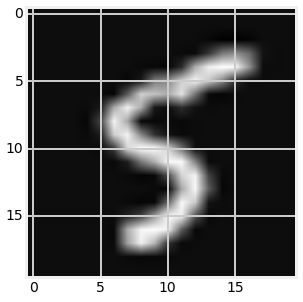

[5]


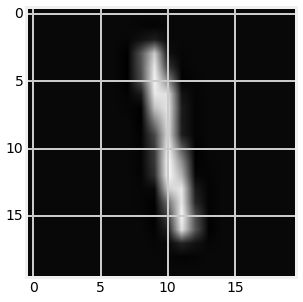

[1]


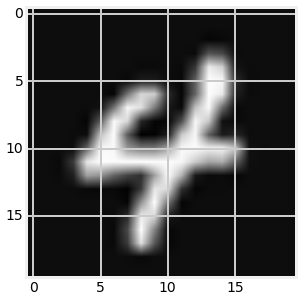

[4]


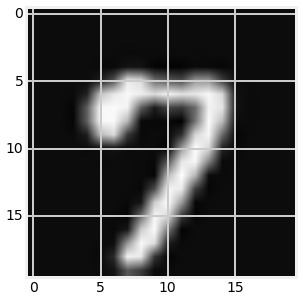

[7]


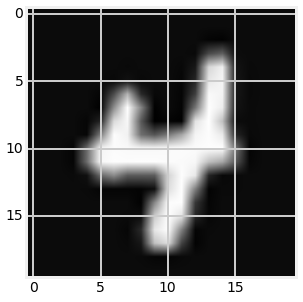

[4]


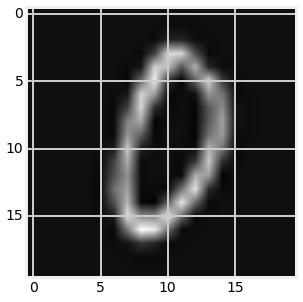

[0]


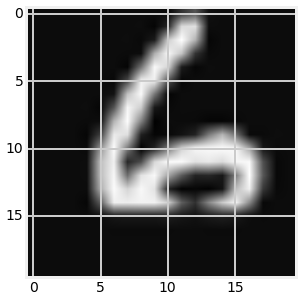

[6]


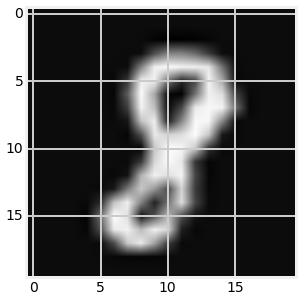

[8]


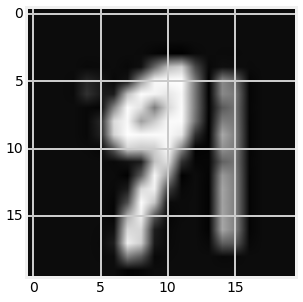

[9]


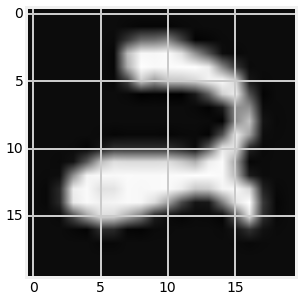

[2]


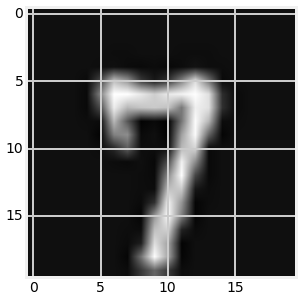

[7]


In [44]:
ix = arange(X.shape[0])
random.shuffle(ix)
maxi = 10
for i in range(X.shape[0]):
    j = ix[i]
    imshow(X[j].reshape((20,20)).T, cmap=cm.Greys_r)
    tight_layout(pad=0)
    show()
    print nn_predict(theta, X[j:j+1], sizes)
    if i >= maxi:
        break